In [1]:
import json

#The sample data
sample_data = [
    {
        "id": 1,
        "correct": "The quick brown fox jumps over the lazy dog.",
        "user": "The quick brown fox jump over lazy dog."
    },
    {
         "id": 2,
        "correct": "She is going to the market to buy fresh vegetables.",
        "user": "She go to market buy fresh vegetable."
    },
    {
        "id": 3,
        "correct": "He doesn’t like playing football in the rain.",
        "user": "He not like play football in rain."
    },
    {
        "id": 4,
        "correct": "We were watching a movie when the lights went out.",
        "user": "We watch movie when lights go out."
    },
    {
         "id": 5,
        "correct": "They have been studying English for two years.",
        "user": "They study English two year."
    }
]

#Save it as a JSON file
with open("dictation_dataset.json", "w") as f:
    json.dump(sample_data, f, indent=1)

print("JSON file created successfully!")

JSON file created successfully!


In [2]:
#For the mlp aspect of the project
import spacy

#For clean printing of the results
from pprint import pprint

#For comparing sequences (like word lists)
from difflib import SequenceMatcher

#For CSV export features to generate usable reports from POS tagging comparisons
#These will help document the errors for later analysis or for sharing with others.
import csv


In [3]:
#Load the sample data set
with open("dictation_dataset.json", "r") as f:
    data = json.load(f)

#Printing the first entry to verify
print(data[0])

{'id': 1, 'correct': 'The quick brown fox jumps over the lazy dog.', 'user': 'The quick brown fox jump over lazy dog.'}


In [4]:
#Load the small engish model from spacy
nlp = spacy.load("en_core_web_sm")

# Mapping POS tags to human-readable descriptions
pos_descriptions = {
    "ADJ": "Adjective",
    "ADP": "Adposition",
    "ADV": "Adverb",
    "AUX": "Auxiliary",
    "CONJ": "Conjunction", 
    "CCONJ": "Coordinating Conjunction",
    "DET": "Determiner", 
    "INTJ": "Interjection",
    "NOUN": "Noun",
    "NUM": "Numeral", 
    "PART": "Particle",
    "PRON": "Pronoun",
    "PROPN": "Proper Noun",
    "PUNCT": "Punctuation",
    "SCONJ": "Subordinating Conjunction",
    "SYM": "Symbol",
    "VERB": "Verb",
    "X": "Other"
}


In [5]:
#Defining a function to POS tag sentences
def get_pos_tags(text):
    #This processes the sentences
    doc = nlp(text)
    return[(token.text, token.pos_) for token in doc]# Use square brackets [] to make it a list

In [6]:
#Comparing POS Tags between the correct sentence and the user sentence
def compare_pos_tags(correct_sentence, user_sentence):
    #Processing both the correct and user sentences with spaCy to tokenize and POS tag
    correct_doc = nlp(correct_sentence)
    user_doc = nlp(user_sentence)

    #Extracting word tokens as lists of strings
    correct_tokens = [token.text for token in correct_doc]
    user_tokens = [token.text for token in user_doc]

    #Extracting corresponding POS tags for each token
    correct_pos = [token.pos_ for token in correct_doc]
    user_pos = [token.pos_ for token in user_doc]

    #Using the difflib imported to match the sequences of words and detect edits
    matcher = SequenceMatcher(None, correct_tokens, user_tokens)

    result = []  #This will hold our comparison results

    #Iterating over the sequence of edit operations from difflib
    for opcode, i1, i2, j1, j2 in matcher.get_opcodes():
        # CASE 1: Tokens are equal at these positions
        if opcode == 'equal':
            for k in range(i2 - i1):
                result.append({
                    "type": "match",  # No error
                    "correct_word": correct_tokens[i1 + k],
                    "user_word": user_tokens[j1 + k],
                    "correct_pos": correct_pos[i1 + k],
                    "user_pos": user_pos[j1 + k],
                    "error": False
                })

        # CASE 2: Tokens are different (word or POS mismatch)
        elif opcode == 'replace':
            for k in range(min(i2 - i1, j2 - j1)):  # Match up to smallest length
                result.append({
                    "type": "replace",  # Indicates wrong word or wrong POS
                    "correct_word": correct_tokens[i1 + k],
                    "user_word": user_tokens[j1 + k],
                    "correct_pos": correct_pos[i1 + k],
                    "user_pos": user_pos[j1 + k],
                    "error": True
                })

        # CASE 3: Word(s) in correct sentence are missing from user's (omission)
        elif opcode == 'delete':
            for k in range(i1, i2):
                result.append({
                    "type": "omission",  # Word not included by user
                    "correct_word": correct_tokens[k],
                    "user_word": "",
                    "correct_pos": correct_pos[k],
                    "user_pos": "",
                    "error": True
                })

        # CASE 4: Extra word(s) added by user (not in correct sentence)
        elif opcode == 'insert':
            for k in range(j1, j2):
                result.append({
                    "type": "insertion",  # User added unnecessary word
                    "correct_word": "",
                    "user_word": user_tokens[k],
                    "correct_pos": "",
                    "user_pos": user_pos[k],
                    "error": True
                })

    return result  # Return the full analysis

In [7]:
#Run error analysis for all entries in the dataset
for entry in data:
    print(f"\nSentence ID: {entry['id']}")
    print(f"Correct: {entry['correct']}")
    print(f"User: {entry['user']}")

    results = compare_pos_tags(entry['correct'], entry['user'])
    for r in results:
        print(r)


Sentence ID: 1
Correct: The quick brown fox jumps over the lazy dog.
User: The quick brown fox jump over lazy dog.
{'type': 'match', 'correct_word': 'The', 'user_word': 'The', 'correct_pos': 'DET', 'user_pos': 'DET', 'error': False}
{'type': 'match', 'correct_word': 'quick', 'user_word': 'quick', 'correct_pos': 'ADJ', 'user_pos': 'ADJ', 'error': False}
{'type': 'match', 'correct_word': 'brown', 'user_word': 'brown', 'correct_pos': 'ADJ', 'user_pos': 'ADJ', 'error': False}
{'type': 'match', 'correct_word': 'fox', 'user_word': 'fox', 'correct_pos': 'NOUN', 'user_pos': 'NOUN', 'error': False}
{'type': 'replace', 'correct_word': 'jumps', 'user_word': 'jump', 'correct_pos': 'VERB', 'user_pos': 'NOUN', 'error': True}
{'type': 'match', 'correct_word': 'over', 'user_word': 'over', 'correct_pos': 'ADP', 'user_pos': 'ADP', 'error': False}
{'type': 'omission', 'correct_word': 'the', 'user_word': '', 'correct_pos': 'DET', 'user_pos': '', 'error': True}
{'type': 'match', 'correct_word': 'lazy', 'u

In [8]:
#Grouping the errors by POS tag type, so we'll know, for example, whether most mistakes happen with verbs, nouns, or determiners.
#This will help us later build insights and plot charts

from collections import defaultdict

def group_errors_by_pos(results):
    #Creating counters for each type of error and POS involved
    pos_errors = {
        "replace": defaultdict(int),
        "omission": defaultdict(int),
        "insertion": defaultdict(int)
    }

    #Going through each comparison result
    for entry in results:
        if not entry['error']:
            continue  # Skip non-errors

        if entry['type'] == "replace":
            #Using the correct POS (or user POS), both could be useful
            pos_errors["replace"][entry['correct_pos']] += 1

        elif entry['type'] == "omission":
            pos_errors["omission"][entry['correct_pos']] += 1

        elif entry['type'] == "insertion":
            pos_errors["insertion"][entry['user_pos']] += 1

    return pos_errors

In [9]:
#Combining all error results from all sentence pairs
all_results = []

for entry in data:
    comparison = compare_pos_tags(entry["correct"], entry["user"])
    all_results.extend(comparison)


# Export detailed POS error log to CSV
with open("pos_error_details.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    # Header row
    writer.writerow([
        "Sentence_ID", "Error_Type", "Correct_Word", "User_Word",
        "Correct_POS", "Correct_POS_Label", "User_POS", "User_POS_Label"
    ])

    for entry in data:
        comparison = compare_pos_tags(entry["correct"], entry["user"])
        for result in comparison:
            if result["error"]:  # Only export actual errors
                writer.writerow([
                    entry["id"],
                    result["type"],
                    result["correct_word"],
                    result["user_word"],
                    result["correct_pos"],
                    pos_descriptions.get(result["correct_pos"], "N/A"),
                    result["user_pos"],
                    pos_descriptions.get(result["user_pos"], "N/A")
                ])
                

#Grouping the errors
grouped_errors = group_errors_by_pos(all_results)

# Export grouped error counts to a summary CSV
with open("pos_error_summary.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Error_Type", "POS_Tag", "POS_Description", "Count"])

    for error_type, pos_counts in grouped_errors.items():
        for pos_tag, count in pos_counts.items():
            writer.writerow([
                error_type,
                pos_tag,
                pos_descriptions.get(pos_tag, "Unknown"),
                count
            ])

#Printing the breakdown
for error_type, pos_counts in grouped_errors.items():
    print(f"\n{error_type.upper()} Errors:")
    for pos_tag, count in pos_counts.items():
        pos_label = pos_descriptions.get(pos_tag, "Unknown")
        print(f"  {pos_tag} ({pos_label}): {count}")



REPLACE Errors:
  VERB (Verb): 3
  AUX (Auxiliary): 4
  NOUN (Noun): 2

OMISSION Errors:
  DET (Determiner): 4
  PART (Particle): 1
  ADP (Adposition): 1

INSERTION Errors:


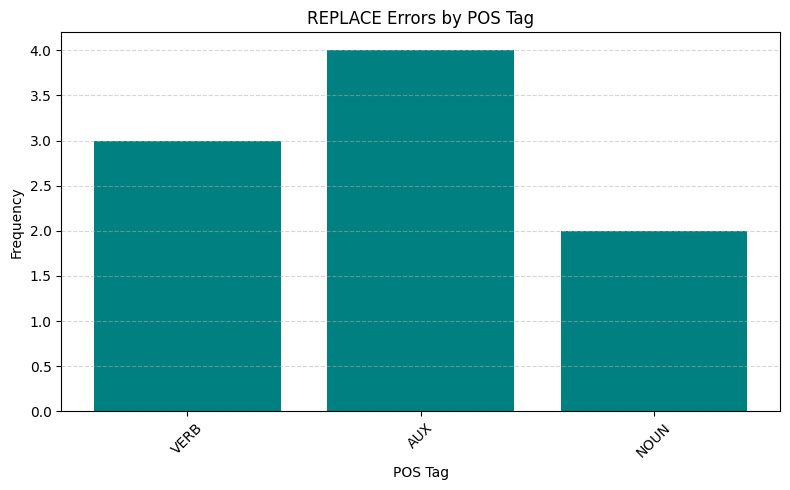

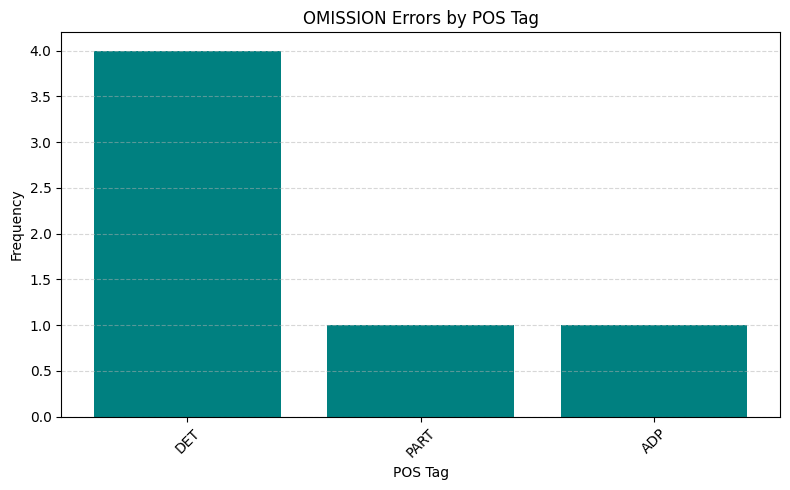

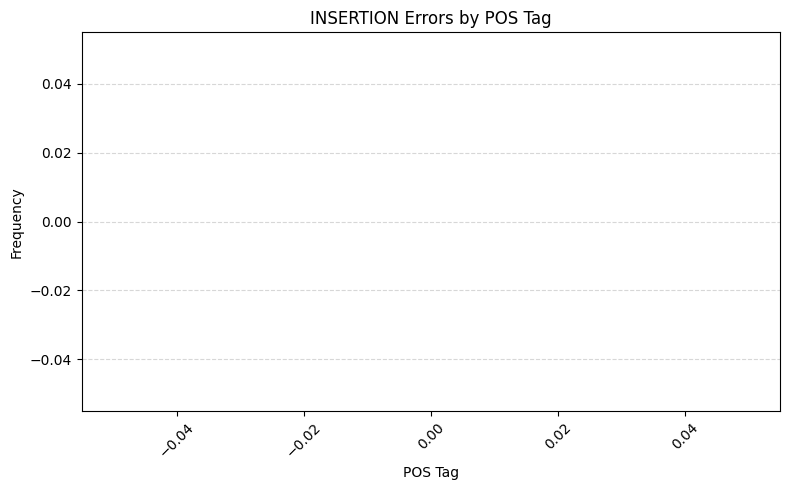

In [10]:
 #POS Error Visualization with Matplotlib
# Required imports
%matplotlib inline
import matplotlib.pyplot as plt

# Visualization function
def plot_pos_errors(grouped_errors):
    for error_type, pos_counts in grouped_errors.items():
        pos_tags = list(pos_counts.keys())
        frequencies = list(pos_counts.values())

        plt.figure(figsize=(8, 5))
        plt.bar(pos_tags, frequencies, color='teal')

        plt.xlabel("POS Tag")
        plt.ylabel("Frequency")
        plt.title(f"{error_type.upper()} Errors by POS Tag")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Call it with your grouped error data
plot_pos_errors(grouped_errors)
